In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

data_100k = 'ml-100k/u.data'

In [2]:
df = pd.read_csv(data_100k ,header=None, sep='\t',names=["user_id", "movie_id", "rating","timestamp"])
n_users, n_items = df['user_id'].unique().shape[0], df['movie_id'].unique().shape[0]
# user_ratings = user_ratings.sort_values('user_id').reset_index(drop = True)
df = df.drop(columns='timestamp')
df.head(5)

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [3]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [0]:

def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
    assert(np.all((train * test) == 0)) 
    return train, test
train, test = train_test_split(ratings)

In [0]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)
user_similarity = fast_similarity(train, kind='user')

In [0]:
def predict_fast_simple(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T

In [0]:
from sklearn.metrics import mean_squared_error
def get_rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

In [26]:
user_prediction = predict_fast_simple(train, user_similarity, kind='user')
print ('User-based CF MSE: ' + str(get_mse(user_prediction, test)))

User-based CF MSE: 8.44798843698731


In [27]:
import warnings
warnings.filterwarnings("ignore")
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(tuple(ratings.shape))
    if kind == 'user':
        for i in range(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in range(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))       
    
    return pred
pred = predict_topk(train, user_similarity, kind='user', k=40)
print ('Top-k User-based CF MSE: ' + str(get_rmse(pred, test)))

Top-k User-based CF MSE: 2.561618045969998


In [0]:
k_array = [5, 15, 30, 40, 50, 60, 100, 120]
user_train_rmse = []
user_test_rmse = []
for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    user_train_rmse += [get_rmse(user_pred, train)]
    user_test_rmse += [get_rmse(user_pred, test)]

k=5, RMSE in test result=2.9338664734623685
k=15, RMSE in test result=2.656601601800383
k=30, RMSE in test result=2.5738825005413783
k=40, RMSE in test result=2.561618045969998
k=50, RMSE in test result=2.5581817833767726
k=60, RMSE in test result=2.5591212450249663
k=100, RMSE in test result=2.571963803276884
k=120, RMSE in test result=2.5814980116501522


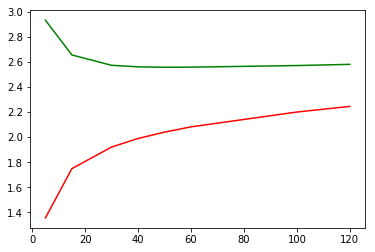

In [62]:
for i in range(len(k_array)):
  print(f'k={k_array[i]}, RMSE in test result={user_test_rmse[i]}')
import matplotlib.pyplot as plt
plt.plot(k_array, user_train_rmse, color='red', label='test result')
plt.plot(k_array, user_test_rmse, color='green', label='train result')
plt.show()

In [0]:
 #由上可知，最优的k落在k=40和k=60之间
k_array = []
for i in range(40,61):
  k_array.append(i)
user_train_rmse = []
user_test_rmse = []
for k in k_array:
    user_pred = predict_topk(train, user_similarity, kind='user', k=k)
    user_train_rmse += [get_rmse(user_pred, train)]
    user_test_rmse += [get_rmse(user_pred, test)]

k=40, RMSE in test result=2.561618045969998
k=41, RMSE in test result=2.560750735364401
k=42, RMSE in test result=2.5600857867919378
k=43, RMSE in test result=2.5599390467800966
k=44, RMSE in test result=2.559211802370459
k=45, RMSE in test result=2.558837269084845
k=46, RMSE in test result=2.5579681766213476
k=47, RMSE in test result=2.5578815265455295
k=48, RMSE in test result=2.558096499535581
k=49, RMSE in test result=2.5580832730095593
k=50, RMSE in test result=2.5581817833767726
k=51, RMSE in test result=2.557118043125199
k=52, RMSE in test result=2.557742854964676
k=53, RMSE in test result=2.557728631556633
k=54, RMSE in test result=2.5579471125162
k=55, RMSE in test result=2.557767213183528
k=56, RMSE in test result=2.5582653297288465
k=57, RMSE in test result=2.559018411252615
k=58, RMSE in test result=2.559128233368442
k=59, RMSE in test result=2.5592435509242155
k=60, RMSE in test result=2.5591212450249663


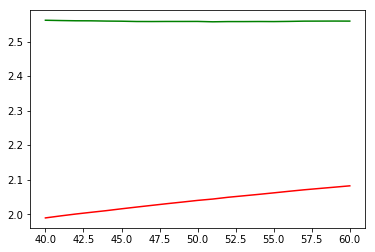

In [69]:
for i in range(len(k_array)):
  print(f'k={k_array[i]}, RMSE in test result={user_test_rmse[i]}')
import matplotlib.pyplot as plt
plt.plot(k_array, user_train_rmse, color='red', label='test result')
plt.plot(k_array, user_test_rmse, color='green', label='train result')
plt.show()

In [0]:
#最优的k=51, RMSE in test result=2.557118043125199